In [ ]:
###Forecasting with an RNN

In [1]:
###Setup

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

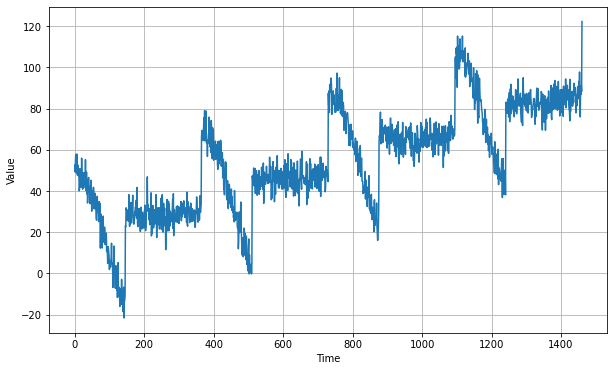

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
###Simple RNN Forecasting

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1),
                       input_shape = [None]),
    keras.layers.SimpleRNN(100, return_sequences = True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 5s 96ms/step - loss: 56.7841 - mae: 57.2840
Epoch 2/100
8/8 [==============================] - 1s 41ms/step - loss: 20.7912 - mae: 21.2816
Epoch 3/100
8/8 [==============================] - 0s 39ms/step - loss: 21.4338 - mae: 21.9281
Epoch 4/100
8/8 [==============================] - 0s 41ms/step - loss: 17.3766 - mae: 17.8683
Epoch 5/100
8/8 [==============================] - 0s 39ms/step - loss: 15.5281 - mae: 16.0177
Epoch 6/100
8/8 [==============================] - 0s 39ms/step - loss: 14.7527 - mae: 15.2405
Epoch 7/100
8/8 [==============================] - 0s 40ms/step - loss: 15.4067 - mae: 15.8935
Epoch 8/100
8/8 [==============================] - 0s 40ms/step - loss: 15.3333 - mae: 15.8237
Epoch 9/100
8/8 [==============================] - 0s 39ms/step - loss: 14.1438 - mae: 14.6292
Epoch 10/100
8/8 [==============================] - 0s 40ms/step - loss: 13.8240 - mae: 14.3111
Epoch 11/100
8/8 [==============================]

8/8 [==============================] - 0s 37ms/step - loss: 3441.8446 - mae: 3442.3446
Epoch 86/100
8/8 [==============================] - 0s 35ms/step - loss: 3916.3785 - mae: 3916.8785
Epoch 87/100
8/8 [==============================] - 0s 37ms/step - loss: 3944.2382 - mae: 3944.7382
Epoch 88/100
8/8 [==============================] - 0s 36ms/step - loss: 4570.8157 - mae: 4571.3156
Epoch 89/100
8/8 [==============================] - 0s 36ms/step - loss: 5338.2871 - mae: 5338.7871
Epoch 90/100
8/8 [==============================] - 0s 36ms/step - loss: 5994.1270 - mae: 5994.6270
Epoch 91/100
8/8 [==============================] - 0s 40ms/step - loss: 6764.6264 - mae: 6765.1264
Epoch 92/100
8/8 [==============================] - 0s 35ms/step - loss: 7388.9310 - mae: 7389.4312
Epoch 93/100
8/8 [==============================] - 0s 35ms/step - loss: 8326.2194 - mae: 8326.7194
Epoch 94/100
8/8 [==============================] - 0s 35ms/step - loss: 9123.3183 - mae: 9123.8183
Epoch 95/100


(1e-07, 0.0001, 0.0, 30.0)

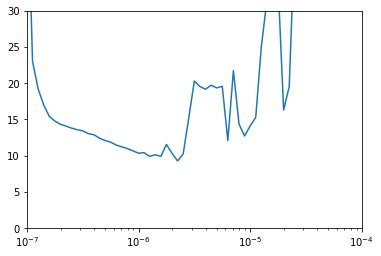

In [6]:
plt.semilogx(history.history["lr"],history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size = 128)
valid_set = window_dataset(x_valid, window_size, batch_size = 128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

optimizer = keras.optimizers.SGD(lr = 1.5e-6, momentum = 0.9)
model.compile(loss = keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience = 50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only = True)
model.fit(train_set, epochs = 500,
          validation_data = valid_set,
          callbacks = [early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 6s 387ms/step - loss: 62.2648 - mae: 62.7631 - val_loss: 53.7729 - val_mae: 54.2729
INFO:tensorflow:Assets written to: my_checkpoint\assets
Epoch 2/500
8/8 [==============================] - 1s 60ms/step - loss: 36.4884 - mae: 36.9860 - val_loss: 17.5199 - val_mae: 18.0161
INFO:tensorflow:Assets written to: my_checkpoint\assets
Epoch 3/500
8/8 [==============================] - 1s 69ms/step - loss: 22.5146 - mae: 23.0086 - val_loss: 18.8167 - val_mae: 19.3136
Epoch 4/500
8/8 [==============================] - 1s 65ms/step - loss: 16.8478 - mae: 17.3388 - val_loss: 20.0785 - val_mae: 20.5772
Epoch 5/500
8/8 [==============================] - 1s 63ms/step - loss: 13.6258 - mae: 14.1148 - val_loss: 6.8457 - val_mae: 7.3288
INFO:tensorflow:Assets written to: my_checkpoint\assets
Epoch 6/500
8/8 [==============================] - 1s 75ms/step - loss: 11.3513 - mae: 11.8347 - val_loss: 7.2706 - val_mae: 7.7554
Epoch 7/500
8/8 [==============

8/8 [==============================] - 1s 83ms/step - loss: 6.0686 - mae: 6.5464 - val_loss: 6.6452 - val_mae: 7.1295
Epoch 60/500
8/8 [==============================] - 1s 82ms/step - loss: 5.8397 - mae: 6.3166 - val_loss: 5.5807 - val_mae: 6.0650
Epoch 61/500
8/8 [==============================] - 1s 66ms/step - loss: 5.5744 - mae: 6.0549 - val_loss: 5.1648 - val_mae: 5.6430
Epoch 62/500
8/8 [==============================] - 1s 63ms/step - loss: 5.6225 - mae: 6.1072 - val_loss: 6.7675 - val_mae: 7.2549
Epoch 63/500
8/8 [==============================] - 1s 60ms/step - loss: 6.0037 - mae: 6.4846 - val_loss: 5.5542 - val_mae: 6.0376
Epoch 64/500
8/8 [==============================] - 1s 71ms/step - loss: 5.5427 - mae: 6.0220 - val_loss: 5.3563 - val_mae: 5.8395
Epoch 65/500
8/8 [==============================] - 1s 63ms/step - loss: 6.2709 - mae: 6.7539 - val_loss: 5.0565 - val_mae: 5.5311
Epoch 66/500
8/8 [==============================] - 1s 64ms/step - loss: 5.7070 - mae: 6.1900 - 

8/8 [==============================] - 1s 74ms/step - loss: 5.2628 - mae: 5.7429 - val_loss: 6.3334 - val_mae: 6.8157
Epoch 120/500
8/8 [==============================] - 1s 72ms/step - loss: 5.2784 - mae: 5.7557 - val_loss: 4.9825 - val_mae: 5.4659
Epoch 121/500
8/8 [==============================] - 1s 65ms/step - loss: 5.0233 - mae: 5.4978 - val_loss: 5.5421 - val_mae: 6.0270
Epoch 122/500
8/8 [==============================] - 1s 65ms/step - loss: 5.8362 - mae: 6.3213 - val_loss: 5.3486 - val_mae: 5.8317
Epoch 123/500
8/8 [==============================] - 1s 65ms/step - loss: 5.0828 - mae: 5.5629 - val_loss: 5.4108 - val_mae: 5.8932
Epoch 124/500
8/8 [==============================] - 1s 63ms/step - loss: 4.8931 - mae: 5.3752 - val_loss: 4.9513 - val_mae: 5.4383
Epoch 125/500
8/8 [==============================] - 1s 63ms/step - loss: 5.0624 - mae: 5.5448 - val_loss: 5.1420 - val_mae: 5.6219
Epoch 126/500
8/8 [==============================] - 1s 64ms/step - loss: 4.8069 - mae: 5.

In [8]:
model = keras.models.load_model("my_checkpoint")

In [9]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size: -1],
    window_size)[:, 0]

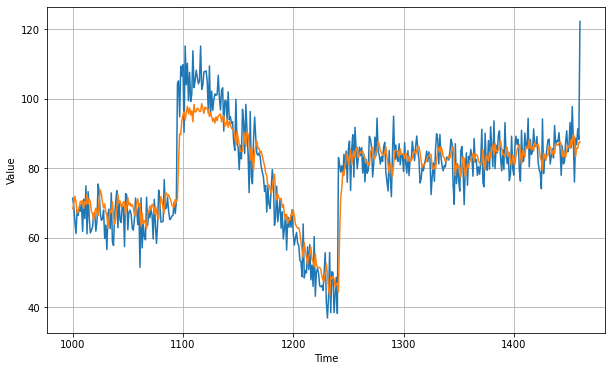

In [10]:
plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [11]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.3282294

In [15]:
###Sequence-to-Sequence Forecasting

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis = -1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [16]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size = 1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[1]
  [2]
  [3]]]
Y: [[[2]
  [3]
  [4]]]
X: [[[2]
  [3]
  [4]]]
Y: [[[3]
  [4]
  [5]]]
X: [[[4]
  [5]
  [6]]]
Y: [[[5]
  [6]
  [7]]]
X: [[[3]
  [4]
  [5]]]
Y: [[[4]
  [5]
  [6]]]
X: [[[5]
  [6]
  [7]]]
Y: [[[6]
  [7]
  [8]]]
X: [[[6]
  [7]
  [8]]]
Y: [[[7]
  [8]
  [9]]]
X: [[[0]
  [1]
  [2]]]
Y: [[[1]
  [2]
  [3]]]


In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                  batch_size = 128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 40ms/step - loss: 57.8162 - mae: 58.3159
Epoch 2/100
8/8 [==============================] - 0s 37ms/step - loss: 24.4221 - mae: 24.9174
Epoch 3/100
8/8 [==============================] - 0s 38ms/step - loss: 26.4627 - mae: 26.9589
Epoch 4/100
8/8 [==============================] - 1s 46ms/step - loss: 21.9066 - mae: 22.4000
Epoch 5/100
8/8 [==============================] - 1s 45ms/step - loss: 19.9172 - mae: 20.4086
Epoch 6/100
8/8 [==============================] - 0s 37ms/step - loss: 18.7127 - mae: 19.2032
Epoch 7/100
8/8 [==============================] - 1s 50ms/step - loss: 18.4776 - mae: 18.9660
Epoch 8/100
8/8 [==============================] - 1s 39ms/step - loss: 18.1116 - mae: 18.6009
Epoch 9/100
8/8 [==============================] - 0s 37ms/step - loss: 17.6015 - mae: 18.0906
Epoch 10/100
8/8 [==============================] - 1s 45ms/step - loss: 16.9587 - mae: 17.4472
Epoch 11/100
8/8 [==============================]

8/8 [==============================] - 0s 37ms/step - loss: 52.4557 - mae: 52.9550
Epoch 87/100
8/8 [==============================] - 1s 42ms/step - loss: 54.4678 - mae: 54.9674
Epoch 88/100
8/8 [==============================] - 0s 40ms/step - loss: 51.9837 - mae: 52.4834
Epoch 89/100
8/8 [==============================] - 0s 40ms/step - loss: 56.3478 - mae: 56.8474
Epoch 90/100
8/8 [==============================] - 0s 38ms/step - loss: 68.4988 - mae: 68.9985
Epoch 91/100
8/8 [==============================] - 0s 40ms/step - loss: 67.0837 - mae: 67.5835
Epoch 92/100
8/8 [==============================] - 0s 36ms/step - loss: 65.0353 - mae: 65.5352
Epoch 93/100
8/8 [==============================] - 0s 38ms/step - loss: 73.8489 - mae: 74.3485
Epoch 94/100
8/8 [==============================] - 0s 41ms/step - loss: 128.6088 - mae: 129.1087
Epoch 95/100
8/8 [==============================] - 1s 46ms/step - loss: 286.2618 - mae: 286.7605
Epoch 96/100
8/8 [==============================]

(1e-07, 0.0001, 0.0, 30.0)

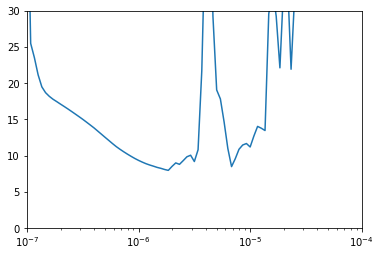

In [18]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [19]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size = 128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size = 128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 5s 168ms/step - loss: 61.3628 - mae: 61.8616 - val_loss: 17.9209 - val_mae: 18.4157
Epoch 2/500
8/8 [==============================] - 1s 65ms/step - loss: 35.1587 - mae: 35.6564 - val_loss: 20.5482 - val_mae: 21.0441
Epoch 3/500
8/8 [==============================] - 1s 64ms/step - loss: 29.5358 - mae: 30.0314 - val_loss: 37.8712 - val_mae: 38.3706
Epoch 4/500
8/8 [==============================] - 1s 75ms/step - loss: 21.7889 - mae: 22.2825 - val_loss: 25.2685 - val_mae: 25.7675
Epoch 5/500
8/8 [==============================] - 1s 74ms/step - loss: 17.9243 - mae: 18.4150 - val_loss: 15.3555 - val_mae: 15.8505
Epoch 6/500
8/8 [==============================] - 1s 70ms/step - loss: 14.9311 - mae: 15.4179 - val_loss: 9.4217 - val_mae: 9.9070
Epoch 7/500
8/8 [==============================] - 1s 66ms/step - loss: 14.3013 - mae: 14.7875 - val_loss: 9.1617 - val_mae: 9.6475
Epoch 8/500
8/8 [==============================] - 1s 83ms/step -

8/8 [==============================] - 1s 72ms/step - loss: 6.3559 - mae: 6.8343 - val_loss: 5.4634 - val_mae: 5.9396
Epoch 64/500
8/8 [==============================] - 1s 68ms/step - loss: 6.1901 - mae: 6.6701 - val_loss: 5.6596 - val_mae: 6.1384
Epoch 65/500
8/8 [==============================] - 1s 67ms/step - loss: 6.2278 - mae: 6.7061 - val_loss: 5.4920 - val_mae: 5.9685
Epoch 66/500
8/8 [==============================] - 1s 65ms/step - loss: 6.3420 - mae: 6.8208 - val_loss: 5.5227 - val_mae: 5.9986
Epoch 67/500
8/8 [==============================] - 1s 62ms/step - loss: 6.2165 - mae: 6.6955 - val_loss: 5.5079 - val_mae: 5.9838
Epoch 68/500
8/8 [==============================] - 1s 62ms/step - loss: 6.3147 - mae: 6.7940 - val_loss: 5.5153 - val_mae: 5.9910
Epoch 69/500
8/8 [==============================] - 1s 62ms/step - loss: 6.2089 - mae: 6.6881 - val_loss: 5.5413 - val_mae: 6.0176
Epoch 70/500
8/8 [==============================] - 1s 61ms/step - loss: 6.3979 - mae: 6.8764 - 

In [20]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

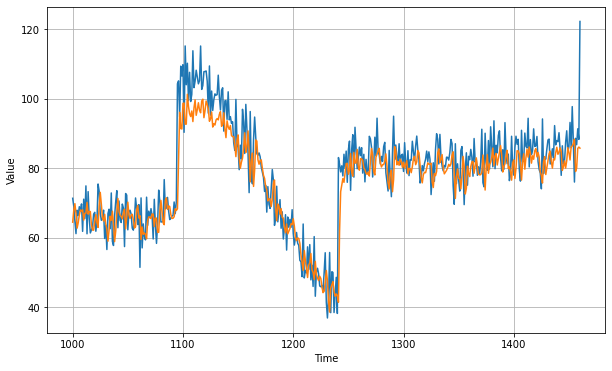

In [21]:
plt.figure(figsize = (10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [22]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.458865